In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
import os
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.font_manager as fm
import tabulate
from scipy.sparse import csgraph
import scipy.stats
import networkx as nx
import itertools
from textwrap import wrap
from sklearn import metrics
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io
import numpy as np
import gget
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib

import sys
sys.path.append("../")
import utils as ut

from mpl_toolkits.mplot3d import Axes3D



In [2]:
# upload the scale factors

keys = ['ND', 'HFD8', 'HFD14']

scales = []

for key in keys:
    path = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/{key}/outs/spatial/scalefactors_json.json"
    
    tmp = pd.read_json(path, lines=True)
    tmp['key'] = key
    # tmp['lowres_spot_diameter_pixels'] = tmp['spot_diameter_fullres'] * tmp['tissue_lowres_scalef']
    # tmp['lowres_spot_diameter_units'] = tmp['lowres_spot_diameter_pixels'] * 65
    
    scales.append(tmp)
    
scales = pd.concat(scales, ignore_index=True)
print(scales)
# print(scales[['key', 'spot_diameter_fullres', 'lowres_spot_diameter_pixels']])



def getscalebar(key, length, scales=scales):
    """Length is physical units """
    lookup = scales.loc[scales['key'] == key]
    pixels = lookup['spot_diameter_fullres'].values[0]
    scaleFactor = lookup['tissue_hires_scalef'].values[0]
    units = 55 # mircons
    fullResPixels = (pixels * length) / units
    lowResPixels = fullResPixels * scaleFactor
    return lowResPixels

def transScaleBar(hiresX, ultrahiresX, lowResPixels):
    """A function to resize the scale bar based on the 
    ultra hir-res image shape """
    newPixels = (lowResPixels * ultrahiresX) / hiresX
    return newPixels

getscalebar('ND', length=100)

   spot_diameter_fullres  tissue_hires_scalef  fiducial_diameter_fullres  \
0             257.195160             0.050684                 415.469120   
1             257.368127             0.051089                 415.748513   
2             257.404844             0.049124                 415.807825   

   tissue_lowres_scalef    key  
0              0.015205     ND  
1              0.015327   HFD8  
2              0.014737  HFD14  


23.701345795450475

In [3]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"


lowres = {}

for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = f.replace(".png", "")
        print(key, img.shape)
        lowres[key] = img

print('done')

HFD14 (2000, 1628)
ND (2000, 1681)
HFD8 (2000, 1692)
done


In [4]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath, engine="openpyxl")
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [5]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [6]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64



,spotId,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells,key
0,AAACAAGTATCTCCCA.1,0.087213,0.113186,0.270488,0.096431,0.057255,0.083130,0.047384,0.163491,0.049659,0.006606,0.025157,HFD8
1,AAACACCAATAACTGC.1,0.159247,0.129071,0.105884,0.002606,0.084753,0.088446,0.016601,0.302068,0.046115,0.038813,0.026395,HFD8
2,AAACAGCTTTCAGAAG.1,0.042437,0.128286,0.329050,0.064440,0.050805,0.049080,0.052493,0.100578,0.065773,0.025274,0.091783,HFD8
3,AAACAGGGTCTATATT.1,0.038153,0.094966,0.294255,0.055503,0.061959,0.060107,0.048176,0.127678,0.099188,0.040547,0.079468,HFD8
4,AAACAGTGTTCCTGGG.1,0.000020,0.256841,0.323585,0.003329,0.015668,0.010229,0.002518,0.222850,0.000587,0.000737,0.163636,HFD8


In [7]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

normalize = True

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        if normalize:
            sdf = ut.normalize(sdf)
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [8]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(14848, 4)
HFD8     6788
ND       4072
HFD14    3988
Name: key, dtype: int64



,spotId,x,y,key
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14
1,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14
2,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14
3,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14
4,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14


In [9]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64


,spotId,x,y,key,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14,3.468007e-02,0.007548,0.409201,0.170860,0.004757,0.041542,0.055275,0.219997,0.010912,0.004188,0.041040
2,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14,1.280364e-03,0.088368,0.187514,0.019633,0.028867,0.129969,0.040070,0.450618,0.008903,0.013757,0.031021
4,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14,3.752028e-04,0.004256,0.283055,0.187004,0.021560,0.108340,0.044845,0.310869,0.003200,0.004016,0.032480
6,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14,1.198581e-07,0.009084,0.239973,0.043516,0.004948,0.057287,0.052469,0.558332,0.000064,0.023214,0.011113
8,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14,1.377525e-02,0.029749,0.216199,0.122802,0.053188,0.158933,0.041466,0.234411,0.043126,0.037127,0.049224


In [10]:
def closest_node(node, nodes, metric):
    closest_index = distance.cdist([node], nodes, metric=metric).argmin()
    return closest_index

def getGraph(kdf, x, y, n=300, metric='minkowski', return_center=True):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]
    centerInd = closest_node([x, y], nodes, metric)
    
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=n,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    
    # create the subgraph
    windowIndices = indices[centerInd]
    mask = kdf.index.isin(windowIndices)
    
    center = kdf[mask].reset_index(drop=True)
    dists = sklearn.metrics.pairwise_distances(center[['x', 'y']], metric=metric)
    
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(center.index, center['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in center.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    
    if return_center:
        return G, center
    else:
        return G
    
    
def getKnn(kdf, k=6, metric='minkowski'):
    """A function to generate a knn graph """
    
    nodes = kdf[['x', 'y']]
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=k+1,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    return indices


def knnInd2Id(kdf, knnInd):
    """Translate neighbors to spotIds """
    
    transId = {}
    
    for i, row in kdf.iterrows():
        spotId = row['spotId']
        nbrhs = kdf.iloc[knnInd[i]]['spotId'].values
        transId[spotId] = nbrhs
    return transId
    
    

def blur(sdf, transId):
    """A function to blur all columns using their neighbors.
    Expects spotIds as index """
    
    results  = []
    
    for spotId, nbhs in transId.items():
        
        t = sdf.loc[nbhs].mean().to_dict()
        t['spotId'] = spotId
        results.append(t)
        
    results = pd.DataFrame(results)
    results = results.set_index('spotId')
    return results


def getCentralities(G):
    """ function to compute centralities """
    cf = pd.DataFrame({'spotId' : G.nodes()})
    cf['degree_centrality'] = cf['spotId'].map(nx.degree_centrality(G))
    cf['betweenness_centrality'] = cf['spotId'].map(nx.betweenness_centrality(G))
    cf['closeness_centrality'] = cf['spotId'].map(nx.closeness_centrality(G))
    cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['eigenvector_centrality'] = cf['spotId'].map(nx.eigenvector_centrality(G, tol=0.001))
    return cf

# quick viz

In [11]:
# key = "HFD14"
# field = "Mac5" # the column to define edgeweights
# networkSize = 150

# edgeRadius = 25 # distance between spots
# sampleSigma = 0.1 # variance around the center of the image
# edgeThresh = 0.6

# kdf = df[df['key'] == key].reset_index(drop=True)

# # sample = kdf.sample(1)
# sample = kdf[kdf['spotId'] == 'CTCCTCCAGCTCACAC.1']
# print(f"{sample['spotId'].values=}")
# sx = sample['x'].values[0]
# sy = sample['y'].values[0]

# # generate the graph 
# G, mf = getGraph(kdf, sx, sy, networkSize)
# node_attr = mf.set_index('spotId').to_dict('index')
# nx.set_node_attributes(G, node_attr)    

# # define connections
# edgelist = []
# for u,v,e in G.edges(data=True):
#     if e['weight'] < edgeRadius:
#         x1 = G.nodes[u][field]
#         x2 = G.nodes[v][field]

#         mean = scipy.stats.hmean([x1, x2])
#         # mean = np.mean([x1, x2])
#         if mean > edgeThresh:
#             edgelist.append((u, v, mean))

# # build the new graph based on connections
# H = nx.Graph()
# H.add_nodes_from(G.nodes())
# H.add_weighted_edges_from(edgelist)
# H.pos = G.pos 

# # add centralities
# cf = getCentralities(H)

# node_attr = cf.set_index('spotId').to_dict('index')
# nx.set_node_attributes(H, node_attr)    

# mf = pd.merge(mf, cf, 
#               left_on='spotId', 
#               right_on='spotId', 
#               how='left')

# components = sorted(nx.connected_components(H), key=len, reverse=True)
# cc = H.subgraph(components[0]).copy()
# original_nodes = list(cc.nodes())
# print(f"{nx.number_of_nodes(cc)=} (before)")

# neighbor_nodes = []

# # add the neighbors
# for node in cc.nodes():
    
#     # get edges in original graph
#     for u,v,e in G.edges(node, data=True):
#         if e['weight'] < edgeRadius:
#             neighbor_nodes.append(u)
#             neighbor_nodes.append(v)

                
# neighbor_nodes = list(set(neighbor_nodes))
# cc.add_nodes_from(neighbor_nodes)
# cc.pos = H.pos

# print(f"{nx.number_of_nodes(cc)=} (after)")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 3.5, 3.5

# node_colors = ['orangered' for x in cc.nodes()]

# node_colors = []

# for n in cc.nodes():
#     if n in original_nodes:
#         node_colors.append("orangered")
#     else:
#         node_colors.append("C0")
        
# print(node_colors)

# # node_colors = [v for k, v in nx.eigenvector_centrality(cc).items()]
# # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["w", "yellow",
# #                                                                 "orangered"])

# # node_colors = np.random.random(len(cc.nodes()))

# nx.draw(cc,
#         cc.pos,
#         edge_color="k",
#         edgecolors='k',
#         linewidths=1.5,
#         node_color=node_colors,
#         # cmap=cmap,
#         width=2,
#         node_size=350)



# plt.gca().set_aspect('equal')

In [12]:
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["w", "yellow",
#                                                                 "orangered"])

# ut.makeColorbar('viridis', 0.3, 2, 'Expression', 'vertical', ["Low", "High"])

# build samples

In [104]:
# sampling networks 

keys = ['ND', 'HFD8', 'HFD14']

field = "Monocytes" # the column to define edgeweights
networkSize = 150
nNetworks = 200 # from each time point
edgeRadius = 25 # distance between spots
sampleSigma = 0.1 # variance around the center of the image
edgeThresh = 0.15

graph = {}
meta = {}
deets = {}

keyInds = np.random.choice(list(range(len(keys))), nNetworks, replace=True)

for i, key in enumerate(keys):

    kdf = df[df['key'] == key].reset_index(drop=True)
    
    for s in range(nNetworks):
        sample = kdf.sample(1)
        sx = sample['x'].values[0]
        sy = sample['y'].values[0]
    
        # generate the graph 
        G, mf = getGraph(kdf, sx, sy, networkSize)

        # # define the node properties
        # mf['norm'] = mf['Mac5'] / mf['Mac5'].max()

        node_attr = mf.set_index('spotId').to_dict('index')
        nx.set_node_attributes(G, node_attr)    

        # define connections
        edgelist = []
        for u,v,e in G.edges(data=True):
            if e['weight'] < edgeRadius:
                x1 = G.nodes[u][field]
                x2 = G.nodes[v][field]

                mean = scipy.stats.hmean([x1, x2])
                # mean = np.mean([x1, x2])
                # if mean > edgeThresh:
                edgelist.append((u, v, mean))

        # build the new graph based on connections
        H = nx.Graph()
        H.add_nodes_from(G.nodes())
        H.add_weighted_edges_from(edgelist)
        H.pos = G.pos 

        # add centralities
        cf = getCentralities(H)

        node_attr = cf.set_index('spotId').to_dict('index')
        nx.set_node_attributes(H, node_attr)    

        mf = pd.merge(mf, cf, 
                      left_on='spotId', 
                      right_on='spotId', 
                      how='left')

        graph[key, s] = H
        meta[key, s] = mf
        deets[key, s] = {
            'key' : key,
            'x' : sx,
            'y' : sy,
        }

print('done')

done


In [14]:
# colors = [
#     '#9835e4',
#     '#e48035',
#     '#8e0152',
#     '#9acd61',
#     '#276419',
# ]

In [15]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 9, 9

# plotBox = 300

# fig, axs = plt.subplots(3, 3)
# axs = axs.ravel()
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgrey", 
#                                                                 "gold", 
#                                                                 "orange", 
#                                                                 "orangered",
#                                                                 "firebrick"])

# plotI = 0


# details = pd.DataFrame.from_dict(deets, orient='index')

# sampleList = []

# for key in keys:
#     tosample = details[details['key'] == key].sample(3)
#     sampleList += tosample.index.to_list()
    

# for i in sampleList:
#     key = deets[i]['key']
#     G = graph[i]
#     mf = meta[i]
    
#     node_color = mf['degree_centrality'].to_list()
    
#     nx.draw(G, G.pos,
#             with_labels=False,
#             ax=axs[plotI], 
#             node_color=node_color,
#             edge_color="k",
#             edgecolors='k',
#             # vmin=0,
#             # vmax=0.2,
#             linewidths=1,
#             width=2,
#             cmap=cmap,
#             node_size=50)
    
    
    
#     img = lowres[key]
#     axs[plotI].imshow(img, 
#                       cmap='binary_r',
#                       alpha=0.6,
#                       zorder=0)
    
#     kdf = df[df['key'] == key].reset_index(drop=True)
    
#     # get the center node index
#     xMid = deets[i]['x']
#     yMid = deets[i]['y']
    
#     xLb = int(xMid - (plotBox / 2))
#     xUb = int(xMid + (plotBox / 2))
    
#     yLb = int(yMid - (plotBox / 2))
#     yUb = int(yMid + (plotBox / 2))

#     axs[plotI].set_ylim([yUb, yLb])
#     axs[plotI].set_xlim([xLb, xUb])    
#     # axs[plotI].set_title(key)
#     axs[plotI].set_xticks([])
#     axs[plotI].set_yticks([])    
    
#     if plotI == 6:
    
#         microns = 100
#         sbarHires = getscalebar(key, microns)

#         scalebar = AnchoredSizeBar(axs[plotI].transData,
#                                sbarHires, 
#                                f'{microns}' + r'$\mu m$', 
#                                loc='lower left', 
#                                # pad=0.2,
#                                color='k',
#                                frameon=False,
#                                size_vertical=1,
#                                zorder=10,
#                                bbox_to_anchor=(0.5, 0.5, 0, 0),
#                                fontproperties={'size':8})
        
#         axs[plotI].add_artist(scalebar)
    
#     plotI += 1
    
# plt.tight_layout()

In [16]:
# ut.makeColorbar(cmap, 0.3, 2, 'Degree', 'vertical', ["Low", "High"])

In [95]:
# # edge distribution
# res = []

# for (key, num), G in graph.items():
    
#     mean_eweight = np.mean([e['weight'] for u, v, e in G.edges(data=True)])
    
#     row = {
#         'key' : key,
#         'num' : num,
#         'mean_eweight' : mean_eweight,
#         'nodes' : nx.number_of_nodes(G),
#         'e2n' :   nx.number_of_edges(G) / nx.number_of_nodes(G)}
    
#     res.append(row)
    
    
# res = pd.DataFrame(res)

# keyMap = {
#     'ND' : 'ND',
#     'HFD8' : '8w',
#     'HFD14' : '14w',
# }

# res['keyName'] = res['key'].map(keyMap)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 4, 2

# sns.histplot(data=res, 
#              x='mean_eweight',
#              bins=30,
#              hue='keyName',
#              # legend=False,
#              palette='viridis')

# sns.despine()
# plt.gca().legend().remove()

# # sns.move_legend(plt.gca(), 
# #                 "upper right", 
# #                 title='',
# #                 frameon=False,)
# plt.ylabel("Number of Networks")
# # plt.xlabel("Mean Edge Weight")
# plt.xlabel("Mac5 Connectivity")
# plt.title('Mac5')

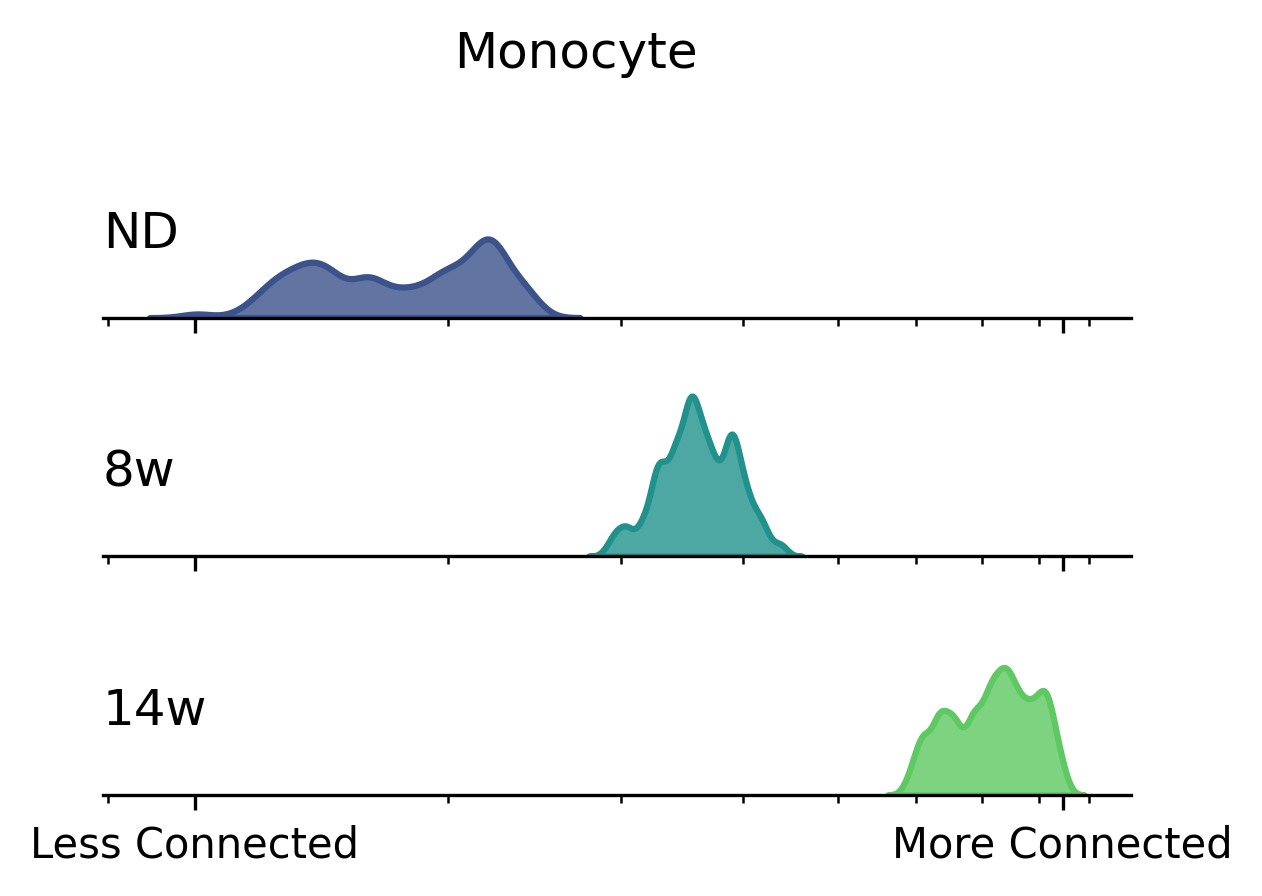

In [105]:
# edge distribution
pdf = []

for (key, num), G in graph.items():
    
    mean_eweight = np.mean([e['weight'] for u, v, e in G.edges(data=True)])
    
    row = {
        'key' : key,
        'num' : num,
        'mean_eweight' : mean_eweight,
        'nodes' : nx.number_of_nodes(G),
        'e2n' :   nx.number_of_edges(G) / nx.number_of_nodes(G)}
    
    pdf.append(row)
    
    
pdf = pd.DataFrame(pdf)

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

pdf['keyName'] = pdf['key'].map(keyMap)


g = sns.FacetGrid(pdf, 
                  row="keyName", 
                  hue="key", 
                  height=1, 
                  aspect=4,
                  palette='viridis')

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean_eweight",
      bw_adjust=.5, 
      clip_on=True,
      common_norm=False,
      fill=True, 
      log_scale=True,
      alpha=0.8, 
      linewidth=1.5)


g.set_titles("")
g.set(ylabel="")

g.despine(bottom=False, 
          right=True,
          left=True)

for ax, label in zip(g.axes.flat, pdf['keyName'].unique()):
    ax.text(0.0, 0.5, label, 
            fontsize=12,
            ha="left", 
            va="center", 
            transform=ax.transAxes)

# plt.xlabel("Mac5 Connectivity")
plt.xlabel("")
plt.suptitle('Monocyte')
plt.tight_layout()
fig = plt.gcf()
_ = plt.xticks([pdf['mean_eweight'].min(), pdf['mean_eweight'].max()], 
           ['Less Connected', 'More Connected'])
_ = plt.yticks([])



In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def thresholdEdges(G, t):
    """ Remove all edges with weight<T from G or its copy. """
    F = G.copy()
    F.remove_edges_from([(u, v) for u, v, e in F.edges(data="weight") if e < t])
    return F

t = 0.15

res = []

for (key, num), G in graph.items():
    F = thresholdEdges(G, t)
    
    degree = [d for n, d in F.degree]
    meanDegree = np.mean(degree)
    
    
    components = sorted(nx.connected_components(F), key=len, reverse=True)
    nComp = len(components)
    sizeLargest = len(components[0])    
    
    row = {
        'key' : key,
        'num' : num,
        'nComp' : nComp,
        'edges' : nx.number_of_edges(F),
        'sizeLargest' : sizeLargest,
        'meanDegree' : meanDegree,
    }
    
    res.append(row)
    
    
res = pd.DataFrame(res)
res.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 2

sns.histplot(data=res, 
             x='meanDegree',
             bins=50,
             hue='key',
             # legend=False,
             palette='viridis')

sns.despine()
# plt.legend(loc='upper right')

sns.move_legend(plt.gca(), "upper right", title='')
plt.ylabel("Number of Networks")
plt.xlabel("Average Degree")

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 3.5
sns.scatterplot(data=res, 
             x='meanDegree',
             y='sizeLargest',
             hue='key',
             ec='None',
             alpha=0.5,
             # legend=False,
             palette='viridis')

sns.despine()
# plt.legend(loc='upper right')

sns.move_legend(plt.gca(), "lower right", title='')
plt.ylabel("Largest Connected Component")
plt.xlabel("Average Degree")

In [ ]:
 # components = sorted(nx.connected_components(F), key=len, reverse=True)
#     sizeLargest = len(components[0])    
    
#     fiedler = 0.0
#     if sizeLargest > 10:
        
#         cc = G.subgraph(components[0])
        
#         # get normalized laplacian
#         A = nx.adjacency_matrix(cc).todense()
    

#         L = csgraph.laplacian(A, normed=True, symmetrized=True)
#         evals, evecs = np.linalg.eigh(L)
#         fiedler = evals[1]
#         fiedler = fiedler * A.shape[0]

#     row = {
#         'key' : key,
#         'num' : num,
#         'density' : nx.density(F),
#         'clustering' : nx.average_clustering(F),
#     }
    
#     res.append(row)


In [ ]:
def thresholdEdges(G, t):
    """ Remove all edges with weight<T from G or its copy. """
    F = G.copy()
    F.remove_edges_from([(u, v) for u, v, e in F.edges(data="weight") if e < t])
    return F


def getOHT(A):
    u, s, vh = np.linalg.svd(A)
    m = u.shape[0]
    n = vh.shape[0] 
    beta = m / n
    omega = (0.56*beta**3) - (0.95 * beta**2) + (1.82 * beta) + 1.43
    y_med = np.median(s)
    tau = omega * y_med
    s_ind = np.argwhere(s >= tau)
    oht = np.max(s_ind) 
    return oht

t = 0.15
res = []

for (key, num), G in graph.items():
    F = thresholdEdges(G, t)
    A = nx.adjacency_matrix(F).todense()
    rank = np.linalg.matrix_rank(A)
    oht = getOHT(A)

    row = {
        'key' : key,
        'num' : num,
        'rank' : rank,
        'oht' : oht,
        'clustering' : nx.average_clustering(F),
    }
    
    res.append(row)
    
res = pd.DataFrame(res)
res = res.fillna(0)
res['oht'] = np.where(res['oht'] == 149, 0, res['oht']) # handle the zero-matrices

res.head()

sns.scatterplot(data=res, 
                x='oht',
                y='clustering',
                ec='None',
                hue='key',
                alpha=0.5,
                palette='viridis')

sns.despine()
sns.move_legend(plt.gca(), "upper right", title='')
plt.ylabel("Clustering Coefficient")
plt.xlabel("Optimal Hard Threshold")

# DEG

In [ ]:

def thresholdEdges(G, t):
    """ Remove all edges with weight<T from G or its copy. """
    F = G.copy()
    F.remove_edges_from([(u, v) for u, v, e in F.edges(data="weight") if e < t])
    return F

t = 0.3

res = []

for (key, num), G in graph.items():
    if not key in ['HFD8', 'HFD14']:
        continue
        
    F = thresholdEdges(G, t)
    edges = F.edges()
    inNodes = list(set(sum(edges, ())))
    outNodes = [x for x in G.nodes() if not x in inNodes]
    
    nf = pd.DataFrame({
        'node' : inNodes,
    })
    
    nf['type'] = 'connected'
    nf['key'] = key
    res.append(nf) # add connected nodes
        
    
    nf = pd.DataFrame({
        'node' : outNodes,
    })
    
    nf['type'] = 'disconnected'
    nf['key'] = key
    res.append(nf) # add disconnected nodes
    
cdf = pd.concat(res)
print(f"{cdf.shape=}")
cdf = cdf.drop_duplicates(subset=['node', 'key'])
print(f"{cdf.shape=}")
print()
print(cdf['key'].value_counts())
print()
print(cdf['type'].value_counts())
cdf.head()

In [ ]:
res = []

for key in cdf['key'].unique():
    sdf = spt[key]
    
    rdf = cdf[cdf['key'] == key]
    mask = rdf['type'] == 'connected'
    
    inNodes = rdf[mask]['node'].to_list()
    outNodes = rdf[~mask]['node'].to_list()
    
    inNet = sdf[sdf.index.isin(inNodes)]
    outNet = sdf[sdf.index.isin(outNodes)]
    
    for gene in sdf.columns:
        
        score, pval = scipy.stats.ranksums(inNet[gene], 
                                           outNet[gene],
                                           alternative='two-sided')
        imean = inNet[gene].mean()
        omean = outNet[gene].mean()
        
        lfc = np.log2(imean + 0.001) - np.log2(omean + 0.001)
        
        row = {
            'gene' : gene,
            'key' : key,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meaninNet' : imean,
            'meanoutNet' : omean,
        }
        
        res.append(row)
    
res = pd.DataFrame(res)
res.head()

In [ ]:
alpha = 0.05
n = 2

ntests = len(sdf.columns)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sig = res[res['pval'] < alphaHat]
print(sig.shape)
sig['key'].value_counts()

In [ ]:
genes = sig['gene'].to_list()

# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'
ef = gget.enrichr(genes, database=db)
ef = ef.head()

ef2 = ef.overlapping_genes.str.join('|').str.get_dummies()
ef2.index = ef['path_name']
ef2.index = [ '\n'.join(wrap(l, 60)) for l in ef2.index ]
ef2 = ef2.loc[:, (ef2.sum(axis=0) != 0)]
ef2.columns = [str(x).lower().capitalize() for x in ef2.columns]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 9, 1.5

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["w",  
                                                                "orangered"])

sns.heatmap(data=ef2,
            linewidths=0.5,
            linecolor='k',
            cbar=False,
            cmap=cmap)

# plt.xticks(rotation=45)

In [ ]:
genes = sig['gene'].to_list()

# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'
ef = gget.enrichr(genes, database=db)

pdf = ef[['path_name', 'adj_p_val']].reset_index()
pdf['logp'] = pdf['adj_p_val'].apply(lambda x: -np.log10(x))

pdf['pname'] = [ '\n'.join(wrap(l, 40)) for l in pdf['path_name']]
pdf['pname'] = pdf['pname'].str.replace("processing and ", "")
pdf['pname'] = pdf['pname'].str.replace("pathway", "")
pdf['pname'] = pdf['pname'].str.replace("in cancer", "")

pdf.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 2

sns.barplot(data=pdf.head(10),
            x='logp',
            y='pname',
            color='lightgrey',
            edgecolor='k')

plt.ylabel("")
plt.xlabel("p-value (log10)")

ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=8)

sns.despine()
ef.head()

In [ ]:
genes = ef['overlapping_genes'].head(10).to_list()
genes = list(itertools.chain(*genes))

", ".join([x[0].lower().title() for x in Counter(genes).most_common(5)])



# DEG and network centrality

In [ ]:
t = 0.15
res = []

for (key, num), G in graph.items():
    F = thresholdEdges(G, t)
    
    sub = pd.DataFrame({
        'spotId': G.nodes(),
    })
    sub['key'] = key
    sub['graphId'] = num

    sub['degree_centrality'] = sub['spotId'].map(nx.degree_centrality(F))
    sub['eigenvector_centrality'] = sub['spotId'].map(nx.eigenvector_centrality(F, weight='weight', tol=1e-02))
    sub['closeness_centrality'] = sub['spotId'].map(nx.closeness_centrality(F))
    sub['betweenness_centrality'] = sub['spotId'].map(nx.betweenness_centrality(F, weight='weight'))
    res.append(sub)
    
    
res = pd.concat(res, ignore_index=True)
res.head()

In [ ]:
pdf = res.copy()

centCols = ['degree_centrality']

# ,[degree_centrality]
#             'eigenvector_centrality',
#             'closeness_centrality',
#             'betweenness_centrality']

# groupby max to account for the spot appearing in several samples
pdf = pdf.groupby(['spotId', 'key'])[centCols].max().reset_index(drop=False)

pdf.head()

In [ ]:
deg = []

centTresh = 0.5

for key in ['HFD8', 'HFD14']:
    sdf = spt[key]
    cdf = pdf[pdf['key'] == key].reset_index()
    
    # normalize the centralities
    for c in centCols:
        cdf[c] = (cdf[c] - cdf[c].min()) / (cdf[c].max() - cdf[c].min())
        
    # make an aggregate column
    cdf['meanCent'] = cdf[centCols].apply(lambda x: scipy.stats.hmean(x), axis=1)
    
    # determine highly central nodes        
    mask = (cdf['meanCent'] > centTresh)
    inNodes = cdf[mask]['spotId'].to_list()
    outNodes = cdf[~mask]['spotId'].to_list()
    
    print(f"{key=} {len(inNodes)=} {len(outNodes)=}")
    
    inNet = sdf[sdf.index.isin(inNodes)]
    outNet = sdf[sdf.index.isin(outNodes)]
    
    # perform differential expression on highly central nodes
    for gene in sdf.columns:
        score, pval = scipy.stats.ranksums(inNet[gene], 
                                           outNet[gene],
                                           alternative='two-sided')
        imean = inNet[gene].mean()
        omean = outNet[gene].mean()
        
        lfc = np.log2(imean + 0.001) - np.log2(omean + 0.001)
        
        row = {
            'gene' : gene,
            'key' : key,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meaninNet' : imean,
            'meanoutNet' : omean,
        }
        
        deg.append(row)
    
deg = pd.DataFrame(deg)
deg.head()

In [ ]:
alpha = 0.05
n = 2

ntests = len(sdf.columns)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sig = deg[deg['pval'] < alpha]
print(sig.shape)
sig['key'].value_counts()

In [ ]:
sig = sig.sort_values(by='log2foldchange', ascending=False)

n = 30
genes = sig['gene'].head(n).to_list()

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'
ef = gget.enrichr(genes, database=db)

pdf = ef[['path_name', 'adj_p_val']].reset_index()
pdf['logp'] = pdf['adj_p_val'].apply(lambda x: -np.log10(x))

pdf['pname'] = [ '\n'.join(wrap(l, 40)) for l in pdf['path_name']]
# pdf['pname'] = pdf['pname'].str.replace("processing and ", "")
# pdf['pname'] = pdf['pname'].str.replace("pathway", "")
pdf['pname'] = pdf['pname'].str.replace("in cancer", "")

pdf.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 4

sns.barplot(data=pdf.head(10),
            x='logp',
            y='path_name',
            color='lightgrey',
            edgecolor='k')

plt.ylabel("")
plt.xlabel("p-value (log10)")
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=8)


sns.despine()

pd.set_option('display.max_colwidth', 100)
ef[['path_name', 'adj_p_val', 'overlapping_genes']].head(20)

In [ ]:
break

In [ ]:
n = 100

t = pd.DataFrame({
    'x1' : np.linspace(0, 1, n), 
    'x2' : np.linspace(0.5, 0.001, n),
})

t['mean'] = t.mean(axis=1)
t['hmean'] = t[['x1', 'x2']].apply(lambda x: scipy.stats.hmean(x), axis=1)


plt.plot(t['mean'], t['hmean'])